In [1]:
import sklearn
import numpy as np
import scipy as sp
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.decomposition import PCA
import scipy.spatial.distance as sdist
from sklearn.preprocessing import StandardScaler
from numpy.linalg import inv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("TP1_data.csv", index_col=0)
X = data.drop("classe", 1)
y = data.classe.copy()
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.index = data.index

df = pd.concat([X, y], axis=1)

Nous travaillons avec des données normalisées.

## 1. Représentation des données :
(a) En visualisant puis en évaluant quantitativement les relations de corrélation entre les 4
variables de représentation, déterminez s’il est nécessaire d’appliquer une transformation
des variables basée sur l’analyse des composantes principales (ACP). Les relations de
corrélation entre les variables sont-elles similaires pour toutes les 3 classes ?


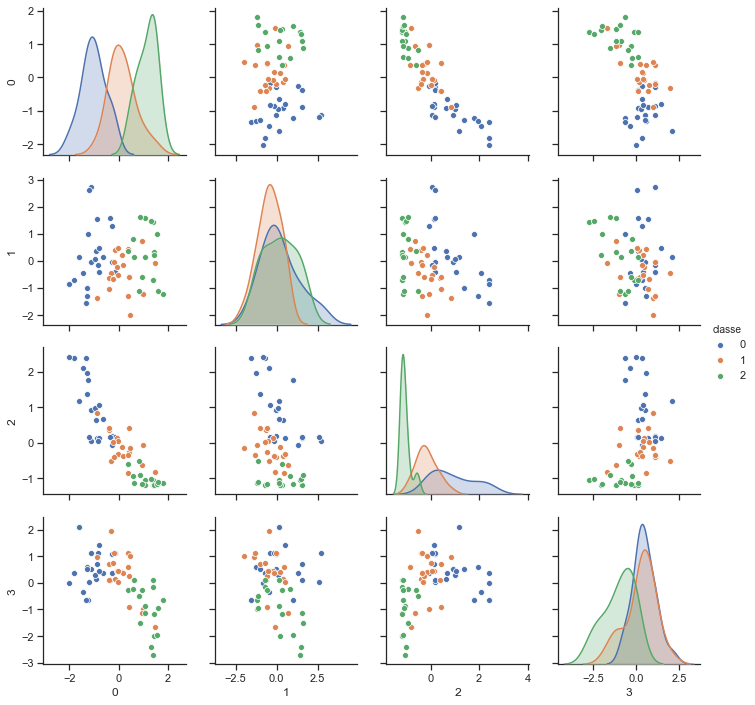

In [3]:
sns.pairplot(df, hue='classe', vars=X)

Les attributs 1 et 3 semblent corrélés. 
On peut le confirmer quantitativement avec une mesure de corrélation de Pearson:

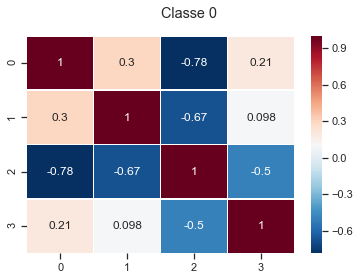

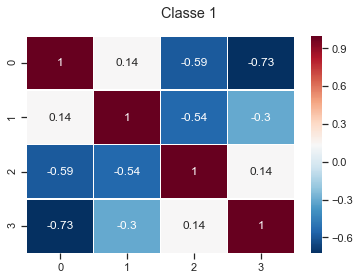

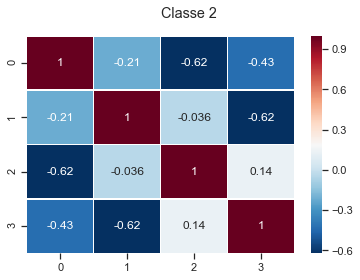

In [4]:
for y_i in y.unique():
    corr = X[df['classe'] == y_i].corr(method='pearson')
    plt.figure(y_i)
    plt.suptitle("Classe %i" %y_i)
    sns.heatmap(corr, 
            xticklabels=corr.columns, yticklabels=corr.columns,
            cmap='RdBu_r', annot=True, linewidth=0.5)
    

On peut confirmer avec ces graphes qu'il y a effectivement une corrélation entre les attributs 1 et 3 pour la classe 0.

In [5]:
########################### TODO : on garde? ####################################
# plots = set()
# for X_i in X.columns:
#     cols = X.columns.drop(X_i)
#     for X_j in cols:
#         if frozenset({X_i, X_j}) not in plots:
#             sns.lmplot(x=X_i, y=X_j, data=df, col='classe', hue='classe')
#         plots.add(frozenset({X_i, X_j}))

(b) En visualisant la séparation entre les 3 classes après transformation par ACP, déterminez
un nombre optimal de composantes principales (CP) à utiliser pour la classification :
2CP ou 3CP. Vérifiez votre réponse en calculant, pour chaque objet, le centroïde dont
il est le plus proche par la distance (Euclidienne) dans les cas 2CP et 3CP, puis en
comparant avec les classes réelles des objets.

### Transformation 2 CP
Transformation ACP et calcul de leurs centroïdes:

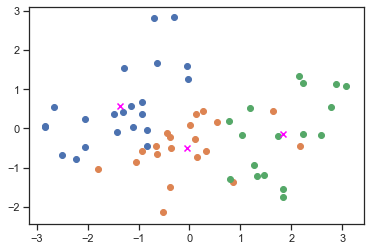

In [6]:
pca_2CP = PCA(n_components=2).fit(X)
pca_2CP_c = []
centroids_2CP = {}
transformed_2CP_c = {}

for y_i in y.unique():
    transformed_2CP_c[y_i] = pca_2CP.transform(df.loc[df['classe'] == y_i].drop('classe', 1))
    centroids_2CP[y_i] = transformed_2CP_c[y_i].mean(axis=0)   
    pca_2CP_c.extend(transformed_2CP_c[y_i])
    plt.scatter(transformed_2CP_c.get(y_i)[:,0], transformed_2CP_c.get(y_i)[:,1])
    plt.scatter(centroids_2CP[y_i][0], centroids_2CP[y_i][1], marker='x', c='fuchsia')    
    plt.title('Réduction à 2CP et centroïdes calculés'')
pca_2CP = pca_2CP.transform(X)

Calcul du nombre d'erreurs de classification effectués à priori après ACP:

Classe 0  - Distance moyenne: 1.126460314509912  - Nombre erreurs : 1
Classe 1  - Distance moyenne: 0.9391954714477233  - Nombre erreurs : 3
Classe 2  - Distance moyenne: 1.1362465426314472  - Nombre erreurs : 2


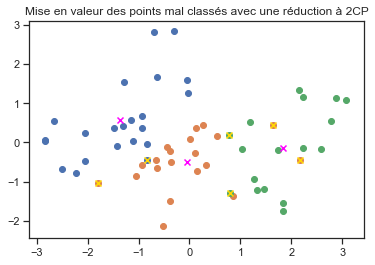

In [43]:
misclassified = {}
dist_2CP = {}
mean_dist_2CP = {}
errors_2CP = {}

for y_i in y.unique():
    errors_2CP[y_i], dist_2CP[y_i], misclassified[y_i]= 0, [], []

for i, point in enumerate(pca_2CP_c):
    dist_to_centroids = [sdist.euclidean(point, centroids_2CP.get(classe)) for classe in range(len(centroids_2CP))]
    dist_2CP[y[i]].append(sdist.euclidean(point, centroids_2CP.get(y[i])))
    y_min_dist = np.argmin(dist_to_centroids)
    if y_min_dist != y[i]:
        errors_2CP[y[i]] += 1
        misclassified[y_i].append(point)

for y_i in y.unique():
    mean_dist_2CP[y_i] = np.mean(dist_2CP.get(y_i))
    print("Classe", y_i,
          " - Distance moyenne:", mean_dist_2CP.get(y_i),
          " - Nombre erreurs :", errors_2CP.get(y_i))
    plt.title('Mise en valeur des points mal classés avec une réduction à 2CP')
    plt.scatter(transformed_2CP_c.get(y_i)[:,0], transformed_2CP_c.get(y_i)[:,1])
    plt.scatter(centroids_2CP[y_i][0], centroids_2CP[y_i][1], marker='x', c='fuchsia')
    for p in misclassified.get(y_i):
        plt.scatter(p[0], p[1], marker='x', c='gold')

### Transformation 3 CP
Transformation ACP et calcul de leurs centroïdes:

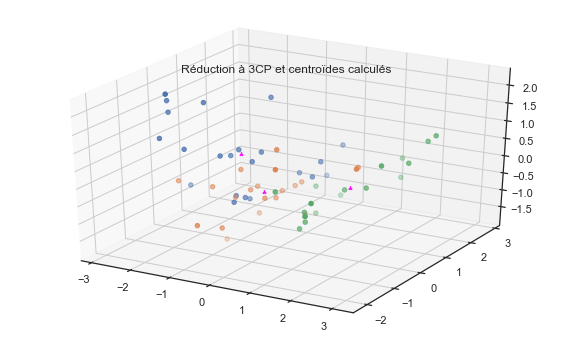

In [84]:
from mpl_toolkits import mplot3d
pca_3CP = PCA(n_components=3).fit(X)
pca_3CP_c = []
centroids_3CP = {}
transformed_3CP_c = {}

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

for y_i in y.unique():
    transformed_3CP_c[y_i] = pca_3CP.transform(df.loc[df['classe'] == y_i].drop('classe', 1))
    centroids_3CP[y_i] = transformed_3CP_c[y_i].mean(axis=0)   
    pca_3CP_c.extend(transformed_3CP_c[y_i])
    ax.scatter(transformed_3CP_c.get(y_i)[:,0], transformed_3CP_c.get(y_i)[:,1], transformed_3CP_c.get(y_i)[:,2])
    ax.scatter(centroids_3CP[y_i][0], centroids_3CP[y_i][1], centroids_3CP[y_i][2], marker='2', c='fuchsia')   
    ax.set_title('Réduction à 3CP et centroïdes calculés')

pca_3CP = pca_3CP.transform(X)

Calcul du nombre d'erreurs de classification effectués à priori après ACP:

Classe 0  - Distance moyenne: 1.4591777253562057  - Nombre erreurs : 2
Classe 1  - Distance moyenne: 1.138652108671962  - Nombre erreurs : 3
Classe 2  - Distance moyenne: 1.273415717662787  - Nombre erreurs : 2


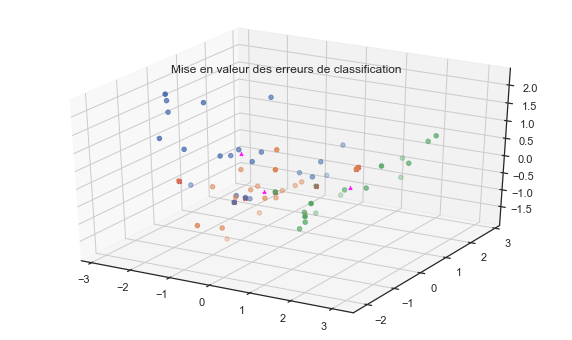

In [86]:
dist_3CP = {}
mean_dist_3CP = {}
errors_3CP = {}
missclassified_3CP = {}

for i in y.unique():
    errors_3CP[i], dist_3CP[i], missclassified_3CP[i]= 0, [], []

for i, point in enumerate(pca_3CP_c):
    dist_to_centroids = [sdist.euclidean(point, centroids_3CP.get(classe)) for classe in range(len(centroids_3CP))]
    dist_3CP[y[i]].append(sdist.euclidean(point, centroids_3CP.get(y[i])))
    y_min_dist = np.argmin(dist_to_centroids)
    if y_min_dist != y[i]:
        errors_3CP[y[i]] += 1
        missclassified_3CP[y[i]].append(point)

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

for y_i in y.unique():
    mean_dist_3CP[y_i] = np.mean(dist_3CP.get(y_i))
    print("Classe", y_i,
          " - Distance moyenne:", mean_dist_3CP.get(y_i),
          " - Nombre erreurs :", errors_3CP.get(y_i))
    ax.scatter(transformed_3CP_c.get(y_i)[:,0], transformed_3CP_c.get(y_i)[:,1], transformed_3CP_c.get(y_i)[:,2])
    ax.scatter(centroids_3CP[y_i][0], centroids_3CP[y_i][1], centroids_3CP[y_i][2], marker='2', c='fuchsia')   
    ax.set_title('Mise en valeur des erreurs de classification')
    for p in missclassified_3CP.get(y_i):
        ax.scatter(p[0], p[1], p[2], marker='X', c='r')

## TODO moyen pour mieux voir points mal classés....
Par l'utilisation de 2 composantes principales, il y a une minimisation légère des erreurs de 
classification donc on peut dont envisager de continuer avec une réduction à 2 CP.  

## 2. Mesure de distance :
(a) D’après les résultats sur l’analyse de corrélation entre les variables de représentation
(1.(a)), quelle mesure de distance (Manhattan, Euclidienne, ou Mahalanobis) entre les
objets serait la plus adéquate ? Vérifiez votre réponse en calculant pour chacune des
mesures de distance, le centroïde le plus proche de chaque objet, puis en comparant avec
les classes réelles des objets.

Nous avons pu effectuer les calculs dans le cas de l'utilisation d'une mesure de 
distance Euclidienne. On s'intéresse maintenant à la mesure de distance Manhattan et Mahalanobis:

In [10]:
def compute_manhattan(point, label):
    dist = [sdist.cityblock(point, centroids_2CP.get(j)) for j in range(len(centroids_2CP))]
    y_min_dist = np.argmin(dist)
    is_error = True if y_min_dist != label else False
    return min(dist), is_error

In [11]:
def compute_mahalanobis(point, label):
    dist = [sdist.mahalanobis(point, centroids_2CP.get(j), covariance_for_class.get(j)) for j in range(len(centroids_2CP))]
    y_min_dist = np.argmin(dist)
    is_error = True if y_min_dist != label else False
    return min(dist), is_error

def compute_mahalanobis_with_cov(point, label, cov_matrix):
    dist = [sdist.mahalanobis(point, centroids_2CP.get(j), cov_matrix) for j in range(len(centroids_2CP))]
    y_min_dist = np.argmin(dist)
    is_error = True if y_min_dist != label else False
    return min(dist), is_error

In [44]:
errors_man, errors_mah = {}, {}
dist_man, dist_mah = {}, {}
misclassified_man, misclassified_mah = {}, {}
for i in y.unique():
    errors_man[i], errors_mah[i]= 0, 0
    dist_man[i], dist_mah[i] = [], []
    misclassified_man[i], misclassified_mah[i] = [], []
    
for i, point in enumerate(pca_2CP):
    d_man, is_error_man = compute_manhattan(point, y[i])
    dist_man[y[i]].append(d_man)
    if is_error_man: 
        errors_man[y[i]] += 1  
        misclassified_man[y[i]].append(point)
        
    d_mah, is_error_mah = compute_mahalanobis_with_cov(point, y[i], inv(np.cov(pca_2CP, rowvar=False)))
    dist_mah[y[i]].append(d_mah)
    if is_error_mah: 
        errors_mah[y[i]] += 1  
        misclassified_mah[y[i]].append(point)

Manhattan, classe 0  - distance moyenne : 1.4106030878965365  - nombre d'erreurs: 3
Manhattan, classe 1  - distance moyenne : 0.977496085773752  - nombre d'erreurs: 3
Manhattan, classe 2  - distance moyenne : 1.3964498599488135  - nombre d'erreurs: 1


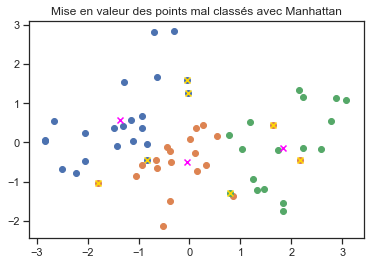

Mahalanobis, classe 0  - distance moyenne : 0.9243525850763281  - nombre d'erreurs: 3
Mahalanobis, classe 1  - distance moyenne : 0.6504635356324736  - nombre d'erreurs: 2
Mahalanobis, classe 2  - distance moyenne : 0.9692409359162046  - nombre d'erreurs: 1


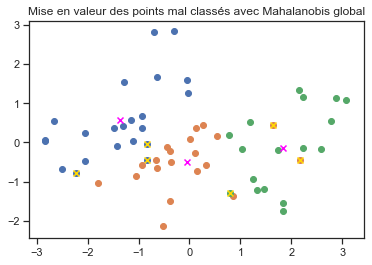

In [49]:
for y_i in y.unique():    
    print("Manhattan, classe", y_i, " - distance moyenne :", np.mean(dist_man.get(y_i)), 
          " - nombre d'erreurs:", errors_man.get(y_i))
    plt.title('Mise en valeur des points mal classés avec Manhattan')
    plt.scatter(transformed_2CP_c.get(y_i)[:,0], transformed_2CP_c.get(y_i)[:,1])
    plt.scatter(centroids_2CP[y_i][0], centroids_2CP[y_i][1], marker='x', c='fuchsia')
    for p_man in misclassified_man.get(y_i):
        plt.scatter(p_man[0], p_man[1], marker='x', c='gold')   
plt.show()
        
for y_i in y.unique():    
    print("Mahalanobis, classe", y_i, " - distance moyenne :", np.mean(dist_mah.get(y_i)), 
          " - nombre d'erreurs:", errors_mah.get(y_i))
    plt.title('Mise en valeur des points mal classés avec Mahalanobis global')
    plt.scatter(transformed_2CP_c.get(y_i)[:,0], transformed_2CP_c.get(y_i)[:,1])
    plt.scatter(centroids_2CP[y_i][0], centroids_2CP[y_i][1], marker='x', c='fuchsia')
    for p_mah in misclassified_mah.get(y_i):
        plt.scatter(p_mah[0], p_mah[1], marker='x', c='gold') 
plt.show()

Avec l'utilisation de la mesure de distance Mahalanobis, nous observons des erreurs de classification moindres 
qu'avec la mesure de distance Manhattan. Avec notre jeu de données, cette mesure de distance semble plus approprié.

(b) Pour la distance de Mahalanobis, on peut utiliser une matrice de covariance par classe
ou une matrice de covariance pour toutes les données. Laquelle des deux options est la
plus adéquate ?

Si les distributions des données sont différentes selons les classes, il est plus 
intéressant de calculer une matrice de covariance pour chaque classe. 
Nous allons voir maintenant si cela s'applique à notre jeu de données:

In [14]:
covariance_for_class = {}
for y_i in y.unique():
    covariance_for_class[y_i] = inv(np.cov(transformed_2CP_c[y_i], rowvar=False))


Mahalanobis, classe 0  - distance moyenne : 1.1993687299703595  - nombre d'erreurs: 2
Mahalanobis, classe 1  - distance moyenne : 1.0168059517041539  - nombre d'erreurs: 4
Mahalanobis, classe 2  - distance moyenne : 1.2458979110350172  - nombre d'erreurs: 2


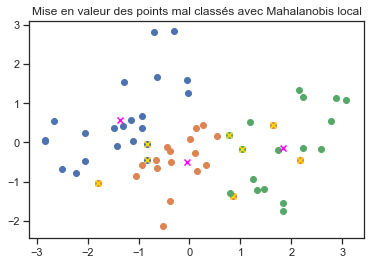

In [87]:
misclassified = {}

errors_mah_c, dist_mah_c = {}, {}
for y_i in y.unique():
    dist_mah_c[y_i], errors_mah_c[y_i], misclassified[y_i] = [], 0, []
    
for i, point in enumerate(pca_2CP):  
    d_mah_c, is_error_mah_c = compute_mahalanobis(point, y[i])
    dist_mah_c[y[i]].append(d_mah_c)
    if is_error_mah_c: 
        errors_mah_c[y[i]] += 1  
        misclassified[y[i]].append(point)

for y_i in y.unique():    
    print("Mahalanobis, classe", y_i, " - distance moyenne :", np.mean(dist_mah_c.get(y_i)), 
          " - nombre d'erreurs:", errors_mah_c.get(y_i))
    plt.title('Mise en valeur des points mal classés avec Mahalanobis local')
    plt.scatter(transformed_2CP_c.get(y_i)[:,0], transformed_2CP_c.get(y_i)[:,1])
    plt.scatter(centroids_2CP[y_i][0], centroids_2CP[y_i][1], marker='x', c='fuchsia')    
    for p in misclassified.get(y_i):
        plt.scatter(p[0], p[1], marker='x', c='gold')    

Avec l'utilisation d'une matrice de covariance pour chaque classe par la mesure de distance Mahalanobis,
nous arrivons à réduire le nombre d'erreurs de classification. 

Voici une comparaison des résultats avec les différentes mesures de distance
pour une réduction à 2 composantes principales:

In [16]:
comparison_errors = pd.DataFrame(columns=['Euclidienne', 'Manhattan', 'Mahalanobis global', 'Mahalanobis local'])
for y_i in y.unique():
    comparison_errors.loc[y_i] = [errors_2CP.get(y_i), errors_man.get(y_i), 
                        errors_mah.get(y_i), errors_mah_c.get(y_i)]
comparison_errors

,Euclidienne,Manhattan,Mahalanobis global,Mahalanobis local
0,1,3,3,2
1,3,3,2,4
2,2,1,1,2


Les mesures de distance Euclidienne et Mahalanobis global donnent des résultats de nombre total d'erreurs
moindres. On peut donc conclure que ceux sont les meilleures options pour notre jeu de données. 

## 3. Choix du modèle de classification :
(a) En utilisant la meilleure représentation des données retenue au Point 1, et la meilleure
mesure de distance retenue au Point 2, tester la méthode des k = 5 plus proches voisins
ou la méthode du plus proche centroïde, et déterminez la plus adéquate.

Au point 1, nous avons pu trouver que la meilleure représentation des données est avec 2 composantes
principales. 
Pour la meilleure mesure de distance, la méthode Euclidienne et celle de Mahalanobis global
donnnent les mêmes performances de classification.  
Nous allons travailler avec ces deux mesures de distance pour la suite du travail. 

In [88]:
cov_matrix = inv(np.cov(pca_2CP, rowvar=False))
nns_mah_metric = lambda x, y : sdist.mahalanobis(x, y, cov_matrix) # métrique de mahalanobis global

knn_euc = KNeighborsClassifier(n_neighbors=5, p=2, n_jobs=-1)
knn_mah = KNeighborsClassifier(n_neighbors=5, 
                               metric='mahalanobis', 
                               metric_params={'VI':  cov_matrix},
                               n_jobs=-1)
nns_euc = NearestCentroid()
nns_mah = NearestCentroid(metric=nns_mah_metric)

names = ["k-NN Euclidienne", "k-NN Mahalanobis global", "NC Euclidienne", "NC Mahalanobis global"]
scores = np.zeros(len(names))

nb_iter = 1000
for it in range(nb_iter):
    X_train, X_test, y_train, y_test = train_test_split(pca_2CP, y, test_size=0.1, stratify=y)
    for i, (n, model) in enumerate(zip(names, [knn_euc, knn_mah, nns_euc, nns_mah])):
        model.fit(X_train, y_train)
        model.predict(X_test)
        scores[i] += model.score(X_test, y_test)
        
print("Score moyen de justesse des modèles k-NN et NNS pour les mesures de distance Euclidienne et Mahalanobis global")
for sc, n in zip(scores, names) :
    print(f"{n}: {sc/nb_iter:%}%")

Score moyen de justesse des modèles k-NN et NNS pour les mesures de distance Euclidienne et Mahalanobis global
k-NN Euclidienne: 88.766667%%
k-NN Mahalanobis global: 86.066667%%
NNS Euclidienne: 89.400000%%
NNS Mahalanobis global: 87.350000%%


On remarque que le modèle Nearest Centroïd avec la mesure de distance Euclidienne produit des résultats légèrement plus performants que les autres.

(b) On fait l’hypothèse que les objets correspondent à des mélanges de distributions gaussiennes correspondant aux classes. Déterminez si cette hypothèse est vraissemblable en
appliquant une classification par modèle de mélange gaussien ("Gaussian Mixture Model”) aux données. Justifiez votre choix parmi les quatre options du modèle pour la
covariance des différentes classes (spherical, diag, tied, ou full).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pca_2CP, y, test_size=0.1, stratify=y)

cov_type = ['full', 'tied', 'diag', 'spherical']
for ct in cov_type:
    gm = GaussianMixture(n_components=3, covariance_type=ct)
    gm.fit(X_train)
    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred == y_train)
    
    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred == y_test) 
    
    print(ct)
    print(f"Justesse entraînement: {train_accuracy:.3%} - test: {test_accuracy:.3%}")

## 4. Application :
À l’aide du modèle retenue au Point 3., déterminez la classe de la nouvelle
observation suivante : [52.1, 23.0, 6.1, 16.5]
